In [ ]:
import torch
import math

# make a simple test image using ellipses
def inside_ellipse(N, theta, ax1, ax2):
    """
    returns a boolean image marking the pixels inside the given ellipse
    """
    x, y = torch.meshgrid(torch.linspace(-1, 1, N), torch.linspace(-1, 1, N))
    x_rot = torch.cos(theta)*x + torch.sin(theta)*y
    y_rot = -torch.sin(theta)*x + torch.cos(theta)*y
    return x_rot**2 / ax1**2 + y_rot**2 / ax2**2 < 1

def make_im(N, thetas, ax1s, ax2s):
    im = torch.zeros(N,N)  

    for ax1, ax2, theta in zip(ax1s, ax2s, thetas):
        im[inside_ellipse(N, theta, ax1, ax2)] += 1
    im = im/im.max()
    return im

# define the image size and the parameters of the ellipses
N = 50
ax1s = [0.2, 0.5]  # solution (anything else is fine)
ax2s = [0.9, 0.7]  # solution
thetas = torch.tensor([0.4*math.pi, 0.4*math.pi])  # solution
im = make_im(N, thetas, ax1s, ax2s)  # ground truth image



In [ ]:
import heat 
alpha=20
Ncount=50
imres=torch.reshape(im,(N**2,1))
A2d=heat.makeA2d(N,alpha)
Fw=torch.matrix_power(A2d, Ncount)
mres=Fw@imres
meas=torch.reshape(mres,(N,N))


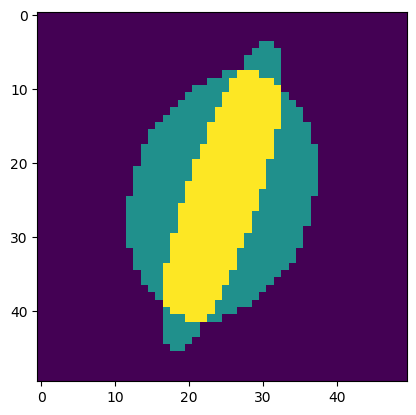

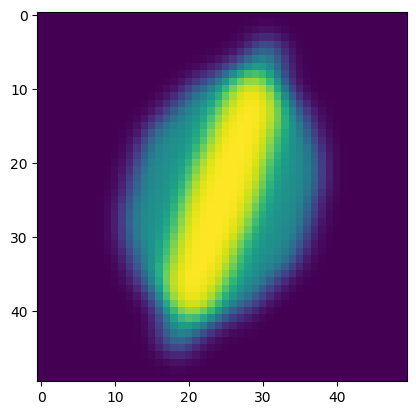

In [ ]:
import matplotlib.pylab as plt
plt.figure()
plt.imshow(im)
plt.figure()
plt.imshow(meas)
plt.show()

In [ ]:


def make_conv(h, n):
    """
    Return a matrix, H, that implements convolution of a length-n signal by h

    if h is length-m, the length of the (valid) convoluation result
    is n-m+1, so H has shape (n-m+1, n)

    h = [1.0, -1.0], n = 4 ->
    H =
    [[-1, 1, 0, 0,],
     [0, -1, 1, 0,],
     [0, 0, -1, 1,]]

    """
    assert h.ndim == 1

    m = len(h)
    pad = n-m # adds to beginning and end
    h_repeat = torch.nn.functional.unfold(
               torch.from_numpy(h).view(1, 1, -1, 1), (n, 1),
               padding=(pad, 0))
    return h_repeat[0].T.flip(1).numpy()


In [ ]:
import numpy as np

n=N**2
m = int(np.sqrt(n))
assert m**2 == n  # n must be perfect square
print(m)
W_horizontal = make_conv(np.array([1.0, -1.0]), n)
W_horizontal = np.delete(W_horizontal, slice(m-1, None, m), axis=0)

h = np.zeros(m+1)
h[0] = -1.0
h[-1] = 1.0
W_vertical = make_conv(h, n)
W = np.concatenate((W_horizontal, W_vertical), axis=0)

50


In [ ]:
import cvxpy as cp
def l1solv(Fw1,W,meas):
# Create variable.
   x_l1 = cp.Variable(shape=(meas.shape[0],1))
   constraints = [x_l1>=0]
# Form objective.
   obj = cp.Minimize(cp.norm(W@x_l1, 1)+cp.norm(Fw1.numpy()@x_l1-meas, 2)**2*1e1)
# Form and solve problem.
   prob = cp.Problem(obj, constraints)
   prob.solve()
   #y = pywt.threshold(x_l1.value[:,0], 4, 'hard')
   #x2 = torch.from_numpy(y)
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   #return torch.norm(x2,0.5)**0.5 + 5e-4*torch.norm(x2,2)**2
   return x2

In [ ]:
xr=l1solv(Fw,W,mres)
recon_reshaped=torch.reshape(mres,(N,N))

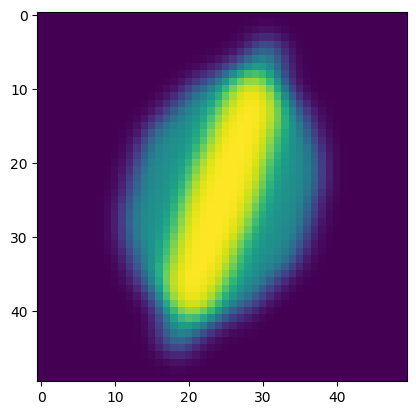

In [ ]:
plt.imshow(recon_reshaped)
plt.show()